# Exploratory Data Analysis (EDA) of Fintech Transactions

**Objective:** To analyze the data from our warehouse to understand customer behavior, identify key trends, and uncover actionable business insights.

**Questions to Answer:**
1. What is the overall distribution of transaction values?
2. Which merchant categories generate the most revenue?
3. How does transaction activity change over time (e.g., by day of the week)?
4. Who are our most valuable customers?

In [1]:
# ### 1. Setup and Data Loading
# 
# First, we import the necessary libraries and establish a connection to our PostgreSQL data warehouse.

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv

# Load environment variables from the .env file in the project root
load_dotenv()

# Set a professional plot style
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# --- Database Connection ---
DWH_DB_USER = os.getenv('DWH_DB_USER')
DWH_DB_PASSWORD = os.getenv('DWH_DB_PASSWORD')
DWH_DB_HOST = os.getenv('DWH_DB_HOST')
DWH_DB_PORT = os.getenv('DWH_DB_PORT')
DWH_DB_NAME = os.getenv('DWH_DB_NAME')

try:
    dwh_engine = create_engine(f"postgresql://{DWH_DB_USER}:{DWH_DB_PASSWORD}@{DWH_DB_HOST}:{DWH_DB_PORT}/{DWH_DB_NAME}")
    print("✅ Connection to Data Warehouse established successfully.")
except Exception as e:
    print(f"❌ Failed to connect to Data Warehouse: {e}")

✅ Connection to Data Warehouse established successfully.


### 2. Data Extraction and Preparation

We'll use a single, comprehensive SQL query to join our fact and dimension tables. This creates a flat, analysis-ready DataFrame, demonstrating the power of our Star Schema.

In [2]:
query = """
SELECT
    f.amount,
    d.full_date,
    d.day_name,
    d.month_name,
    d.year,
    c.first_name,
    m.merchant_name,
    m.category
FROM fact_transactions f
JOIN dim_date d ON f.date_key = d.date_key
JOIN dim_customer c ON f.customer_key = c.customer_key
JOIN dim_merchant m ON f.merchant_key = m.merchant_key;
"""

df = pd.read_sql(query, dwh_engine)
df['full_date'] = pd.to_datetime(df['full_date'])

print("Data loaded successfully. Here's a preview and overview:")
display(df.head())
print("\n--- Data Info ---")
df.info()

Data loaded successfully. Here's a preview and overview:


,amount,full_date,day_name,month_name,year,first_name,merchant_name,category
0,150.75,2025-08-01,Friday,August,2025,Michael,GreenLeaf Grocers,Groceries
1,75.20,2025-08-01,Friday,August,2025,Sarah,The Daily Grind Coffee,Food & Beverage
2,12.50,2025-08-01,Friday,August,2025,Emily,The Daily Grind Coffee,Food & Beverage
3,88.40,2025-08-02,Saturday,August,2025,David,GreenLeaf Grocers,Groceries
4,2500.00,2025-08-02,Saturday,August,2025,Michael,TechSphere Electronics,Electronics



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   amount         10 non-null     float64       
 1   full_date      10 non-null     datetime64[ns]
 2   day_name       10 non-null     object        
 3   month_name     10 non-null     object        
 4   year           10 non-null     int64         
 5   first_name     10 non-null     object        
 6   merchant_name  10 non-null     object        
 7   category       10 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 772.0+ bytes


### 3. Analysis & Visualization

Now we'll address our business questions one by one.

#### Q1: What is the overall distribution of transaction values?

Understanding the distribution helps us identify typical transaction sizes versus outliers (like the high-value transactions we use for fraud alerts).


--- Descriptive Statistics for Transaction Amount ---
count      10.000000
mean      475.825000
std       898.670349
min         8.900000
25%        22.625000
50%        68.600000
75%       135.162500
max      2500.000000
Name: amount, dtype: float64


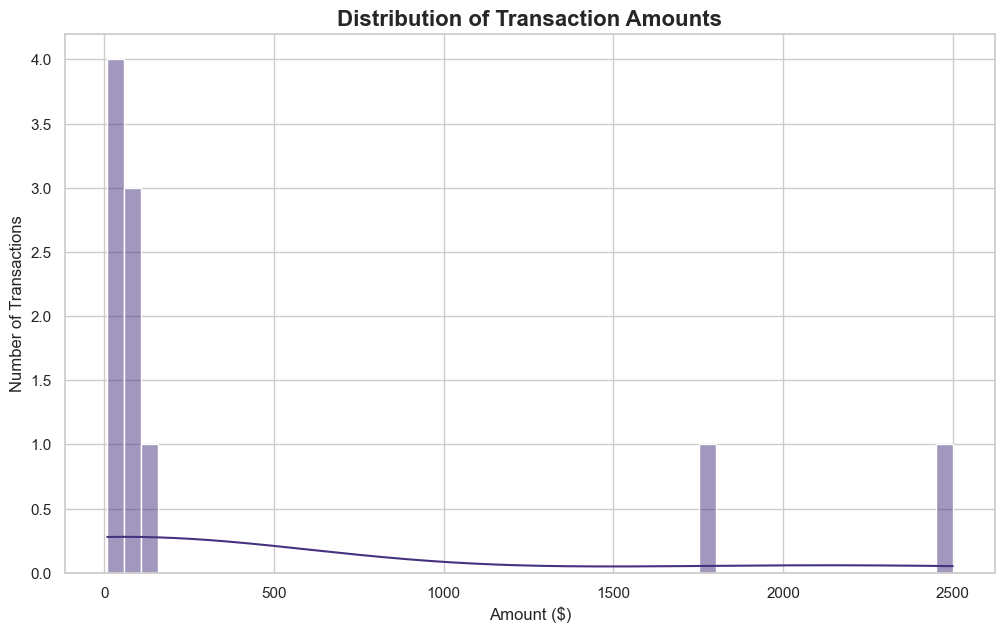

In [3]:
print("\n--- Descriptive Statistics for Transaction Amount ---")
print(df['amount'].describe())

plt.figure()
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts', fontsize=16, weight='bold')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.show()

**Insight:** The distribution is heavily skewed to the right, which is typical for financial data. Most transactions are small, with a long tail of very large, infrequent transactions. This confirms that a simple rule like "amount > $2000" is a reasonable starting point for anomaly detection.

---
#### Q2: Which merchant categories generate the most revenue?

This helps the business team understand which sectors are most valuable and where to focus partnership efforts.


--- Total Spending by Merchant Category ---
category
Electronics        4300.00
Groceries           346.65
Food & Beverage     111.60
Name: amount, dtype: float64


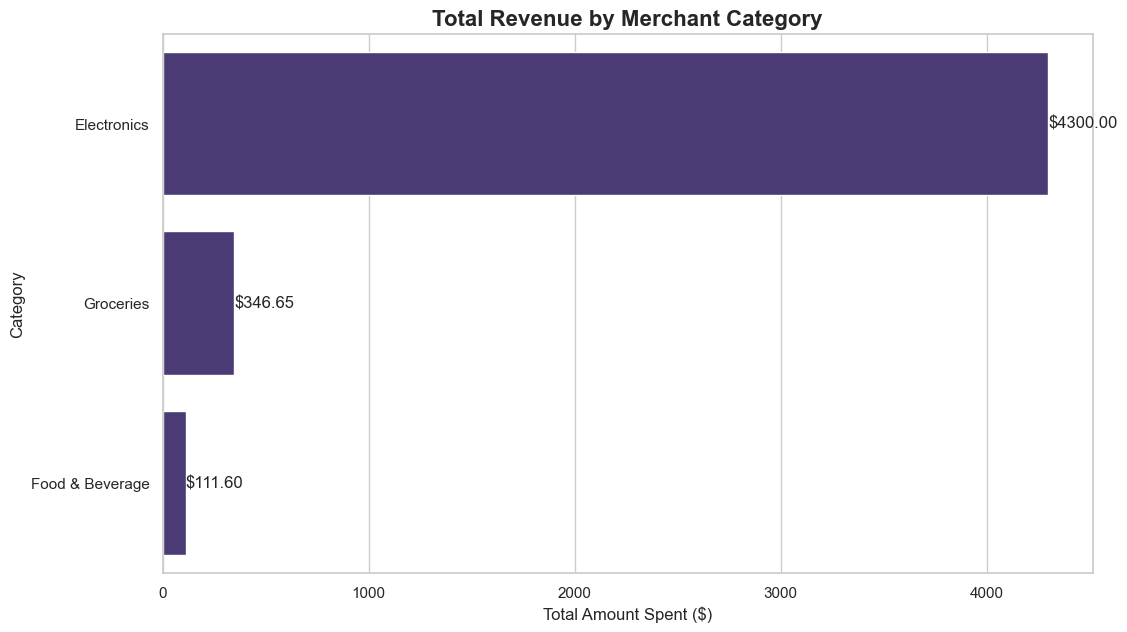

In [4]:
category_spending = df.groupby('category')['amount'].sum().sort_values(ascending=False)

print("\n--- Total Spending by Merchant Category ---")
print(category_spending)

plt.figure()
ax = sns.barplot(y=category_spending.index, x=category_spending.values, orient='h')
plt.title('Total Revenue by Merchant Category', fontsize=16, weight='bold')
plt.xlabel('Total Amount Spent ($)')
plt.ylabel('Category')
# Add labels to the bars
ax.bar_label(ax.containers[0], fmt='$%.2f')
plt.show()

**Insight:** "Electronics" is the highest-grossing category, driven by high-value individual purchases. "Groceries" has more transactions but lower total revenue, indicating smaller, more frequent purchases.

---
#### Q3: How does transaction activity change over time?

We can analyze this by day of the week to understand customer purchasing cycles.


--- Transaction Activity by Day of the Week ---
               sum  count
day_name                 
Monday        8.90      1
Tuesday      62.00      1
Wednesday  1800.00      1
Thursday     15.00      1
Friday      238.45      3
Saturday   2588.40      2
Sunday       45.50      1


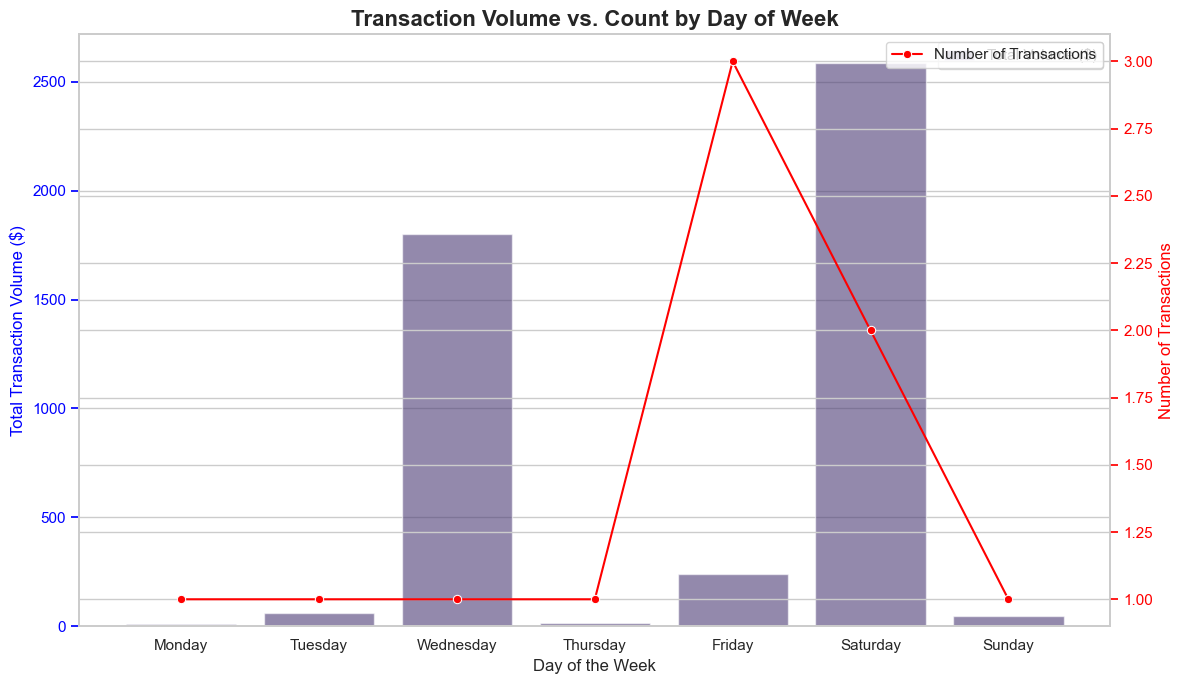

In [5]:
# Order the days of the week correctly for plotting
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_activity = df.groupby('day_name')['amount'].agg(['sum', 'count']).reindex(day_order)

print("\n--- Transaction Activity by Day of the Week ---")
print(daily_activity)

fig, ax1 = plt.subplots()

# Bar plot for total amount
sns.barplot(x=daily_activity.index, y=daily_activity['sum'], ax=ax1, alpha=0.6, label='Total Volume ($)')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Total Transaction Volume ($)', color='b')
ax1.tick_params('y', colors='b')

# Line plot for number of transactions
ax2 = ax1.twinx()
sns.lineplot(x=daily_activity.index, y=daily_activity['count'], ax=ax2, color='r', marker='o', label='Number of Transactions')
ax2.set_ylabel('Number of Transactions', color='r')
ax2.tick_params('y', colors='r')

plt.title('Transaction Volume vs. Count by Day of Week', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

**Insight:** This dual-axis chart reveals a key pattern. While the number of transactions might be steady, the total volume can spike on certain days (e.g., weekends), likely due to larger purchases like electronics.

---
#### Q4: Who are our most valuable customers?

We can identify our top customers based on their total spending.


--- Top 10 Customers by Total Spending ---
first_name
Michael    2665.75
David      1888.40
Chris       107.50
Sarah        84.10
Emily        12.50
Name: amount, dtype: float64


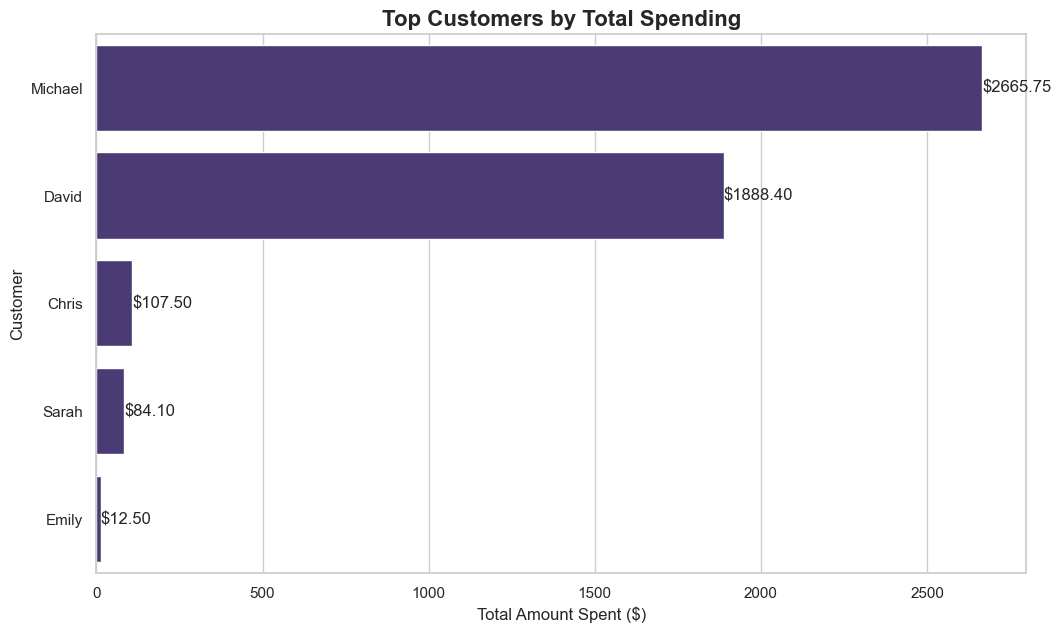

In [6]:
customer_value = df.groupby('first_name')['amount'].sum().sort_values(ascending=False).head(10)

print("\n--- Top 10 Customers by Total Spending ---")
print(customer_value)

plt.figure()
ax = sns.barplot(y=customer_value.index, x=customer_value.values, orient='h')
plt.title('Top Customers by Total Spending', fontsize=16, weight='bold')
plt.xlabel('Total Amount Spent ($)')
plt.ylabel('Customer')
ax.bar_label(ax.containers[0], fmt='$%.2f')
plt.show()

**Insight:** We can clearly identify our VIP customers. This information is critical for marketing, loyalty programs, and personalized customer service.

---
### 4. Summary of Key Findings

* **Transaction Profile:** The business primarily handles a high volume of small transactions, with occasional high-value purchases that are good candidates for fraud monitoring.
* **Top Revenue Sector:** The "Electronics" category is the most significant revenue driver.
* **Customer Behavior:** Customers tend to make larger purchases on specific days, even if the number of transactions remains consistent.
* **VIP Customers:** A small number of customers are responsible for a significant portion of the total transaction value.

**Conclusion:** This analysis, made possible by the data warehouse, provides a clear, multi-faceted view of business operations and customer behavior, enabling data-driven decision-making.